In [1]:
import numpy as np
import sympy as sp
import scipy.optimize as sciopt
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob

from IPython.display import display
import ipywidgets as widgets

import networkx as nx

import jax
jax.config.update("jax_enable_x64", True)

import string
import os
alphabet = string.ascii_lowercase

import jax.numpy as jnp

import sympy as sp
import autolattice.scattering as mss
import autolattice.constraints as msc
import autolattice.architecture_optimizer as arch_opt
import autolattice.plothelpers as phelp
import autolattice.architecture as arch
from autolattice.jax_functions import dot_product
import copy

from itertools import product

from autolattice.helpers import unify_dicts, get_solutions_for_graphs

I0000 00:00:1765293641.892409   24784 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
chain_length = 40  # chain length for which the isolator transport characteristics will be plotted
figures_folder = 'results/isolators/figures'  # save folder for figures
omegas = np.linspace(-6., 6., 301)  # frequency interval in which the characteristics will be plotted

In [3]:
def load_graphs_from_file(load_folder):
    # this function loads the output of run_optimization.py, and extracts the smallest lattice models that fulfill the desired target characteristics (also called irreducible lattices or graphs)
    print('#loading the following code:')
    local_namespace = {}
    with open(os.path.join(load_folder, "setup.py")) as f:
        code = f.read()
        print(code)
        exec(code, globals(), local_namespace)

    optimizer = local_namespace['optimizer']

    optimizer.prepare_all_possible_combinations()
    # plot_functions = phelp.prepare_plot_functions_for_plotting(optimizer, 20)
    all_result_files = sorted(glob.glob(os.path.join(load_folder, '*.npz')))
    num_files = len(all_result_files)
    if num_files % 32 != 0:
        raise Warning('sumething seems odd with the number of result files (%i)'%num_files)
    all_data = [dict(np.load(filename)) for filename in all_result_files]

    unified_dict = unify_dicts(*all_data)
    idxs_success = np.where(unified_dict['success'])
    valid_graphs = unified_dict['graphs_tested'][idxs_success]
    optimizer.valid_combinations = valid_graphs
    optimizer.cleanup_valid_combinations()
    irreducible_graphs = optimizer.valid_combinations
    irreducible_graphs_solutions = get_solutions_for_graphs(irreducible_graphs, unified_dict)

    plot_functions = phelp.prepare_plot_functions_for_plotting(optimizer, chain_length)
    optimizer.plot_functions = plot_functions

    print('found %i irreducible graphs'%len(irreducible_graphs))

    return irreducible_graphs, irreducible_graphs_solutions, optimizer

In [4]:
irreducible_graphs_no_squeezing, irreducible_graphs_solutions_no_squeezing, opt_no_squeezing = load_graphs_from_file('results/isolators/without_squeezing')
irreducible_graphs_squeezing, irreducible_graphs_solutions_squeezing, opt_squeezing = load_graphs_from_file('results/isolators/with_squeezing')

#loading the following code:
save_folder = 'isolators/without_squeezing'

target_scaling_rate = 1.
constraints_scaling = [
    msc.Scaling_Rate_Constraint(target_scaling_rate),
    msc.Scaling_Rate_Constraint(0., gradient_order=1),
    msc.Scaling_Rate_Constraint(0., gradient_order=2),
    msc.Prefactor_Constraint(1.),
    msc.Prefactor_Constraint(0., gradient_order=1),
    msc.Min_Distance_Eigvals()
    # msc.Prefactor_Constraint(0., gradient_order=2),
    # msc.Min_Distance_Eigvals_range(jnp.linspace(-5., 5., 51), 0.01),
    # msc.Stability_Constraint(10),
]

kwargs_bounds = {'bounds_extrinsic_loss': [0., np.inf]}

optimizer = arch_opt.Architecture_Optimizer(
    2,
    mode_types=[True, True, True],
    enforced_constraints=constraints_scaling,
    kappas_free_parameters=[False, True],
    port_intrinsic_losses=[False, False],
    kwargs_optimization = {'num_tests': 20, 'kwargs_bounds': kwargs_bounds},
    pso_parameters={'max_iterations': 5000}
)


972it [00:00, 607852.02it/s]

sorted out 12 graphs, where the unit cells were decoupled



231it [00:00, 8984.29it/s]


found 7 irreducible graphs
#loading the following code:
save_folder = 'isolators/with_squeezing-greater_distance'

target_scaling_rate = 1.
constraints_scaling = [
    msc.Scaling_Rate_Constraint(target_scaling_rate),
    msc.Scaling_Rate_Constraint(0., gradient_order=1),
    msc.Scaling_Rate_Constraint(0., gradient_order=2),
    msc.Scaling_Rate_Constraint(0., gradient_order=3),
    msc.Prefactor_Constraint(1.),
    msc.Prefactor_Constraint(0., gradient_order=1),
    msc.Prefactor_Constraint(0., gradient_order=2),
    # msc.Prefactor_Constraint(0., gradient_order=3),
    # msc.Min_Distance_Eigvals(),
    msc.Min_Distance_Eigvals_range(jnp.linspace(-5., 5., 51), 0.1),
    msc.Stability_Constraint(10),
]

kwargs_bounds = {'bounds_extrinsic_loss': [0., np.inf]}

optimizer = arch_opt.Architecture_Optimizer(
    2,
    mode_types=[True, False, True],
    enforced_constraints=constraints_scaling,
    kappas_free_parameters=[False, True],
    port_intrinsic_losses=[False, False],
    kwargs_

288it [00:00, 573035.84it/s]


sorted out 8 graphs, where the unit cells were decoupled


26it [00:00, 8972.51it/s]


found 3 irreducible graphs


In [5]:
def make_isolator_plot(input_array, plot_functions):
    fig, axes = plt.subplots(ncols=3, figsize=(3*2.3, 2.))
    ax_rate = axes[0]
    ax_prefactor = axes[1]
    ax_gain = axes[2]

    scattering_chain = plot_functions['scattering_func'](omegas, input_array)
    prefactors, scaling_rate, info = plot_functions['scaling_func'](omegas, input_array)

    # print(np.abs(scaling_rate[len(omegas)//2]))

    eigval_colors = ['C2', 'C0', 'C1', 'C3']
    for idx in range(4):
        ax_rate.plot(omegas, np.abs(info['eigvals'][:,idx]), color=eigval_colors[idx])
    # ax_rate.plot(omegas, np.abs(scaling_rate))
    ax_prefactor.plot(omegas, np.abs(prefactors[:,0,0]))
    
    ax_gain.plot(omegas, np.abs(scattering_chain[:,-2,0])**2, label='gain')
    ax_gain.plot(omegas, np.abs(scattering_chain[:,0,-2])**2, label='reverse gain')

    for ax in axes:
        ax.set_xlim(omegas[0], omegas[-1])
        ax.axhline(1., color='gray', ls='dashed', zorder=-100)
        ax.set_xlabel(r'$\omega/\kappa_\mathrm{in}$')
    
    ax_rate.set_ylim(0, 2)
    ax_prefactor.set_ylim(0, 1.2)
    ax_gain.set_ylim(0, 1.2)

    ax_rate.set_ylabel('abs(eigenvalues)')
    ax_prefactor.set_ylabel('prefactor')
    ax_gain.set_ylabel('gain')

    fig.tight_layout(h_pad=0.)

    return fig, axes

def plot_result(irreducible_graphs, irreducible_graphs_solutions, optimizer, save_folder=None, file_prefix=''):
    mode_types = optimizer.mode_types
    num_unit_cells = 5
    list_kwargs_noise = None #[{}, {'opening_angles': [50,55,60]}]
    noise_orientations= [np.pi, 0] #[np.pi, -0.8]
    rows = []
    for idx in range(len(irreducible_graphs)):
        fig_chain, ax, G = arch.draw_chain_cell(
            irreducible_graphs[idx],
            num_following_unit_cells=num_unit_cells-1,
            positions_unit_cell='straight',
            distance_next_unit_cell=1,
            node_colors_unit_cell=['orange', '#D5D5D5'],
            noise_orientations=noise_orientations,
            orientation_detunings=[0, 0.6],
            kwargs_draw={'detuning_radius_factor': 0.6},
            mode_types=mode_types,
            modes_without_noise=[0,-2],
            scale=0.7,
            list_of_kwargs_noise=list_kwargs_noise
        )

        fig_scaling, _ = make_isolator_plot(irreducible_graphs_solutions[idx], optimizer.plot_functions)

        if save_folder is not None:
            filename_chain = file_prefix + str(idx).zfill(3) + '-chain.pdf'
            filename_scaling = file_prefix + str(idx).zfill(3) + '-scaling.pdf'
            # fig_chain.savefig(os.path.join(load_folder, filename_chain))
            # fig_scaling.savefig(os.path.join(save_folder, filename_scaling))
        
        output1 = widgets.Output()
        output2 = widgets.Output()
        label = widgets.HTML(f"<div style='font-size:40px; font-weight:bold;'>{idx}</div>", layout=widgets.Layout(width='70px'))

        with output1:
            display(fig_chain)
        with output2:
            display(fig_scaling)

        hbox = widgets.HBox([label, output1, output2], layout=widgets.Layout(align_items="center"))

        rows.append(hbox)

        plt.close(fig_scaling)
        plt.close(fig_chain)

    vbox = widgets.VBox(rows)
    display(vbox)

Plot all irreducible graphs and the transport characteristics for one of typically many possible continuous parameter sets

In [6]:
plot_result(irreducible_graphs_no_squeezing, irreducible_graphs_solutions_no_squeezing, opt_no_squeezing, save_folder=figures_folder)

In [7]:
plot_result(irreducible_graphs_squeezing, irreducible_graphs_solutions_squeezing, opt_squeezing, save_folder=figures_folder, file_prefix='squeezing-')

As some of the lattice models above are identical up to transformations, we select only unique ones
The following plots are those included in the Supplemental Material Fig 1 

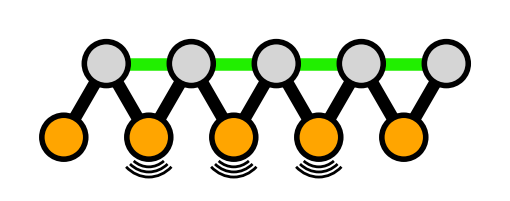

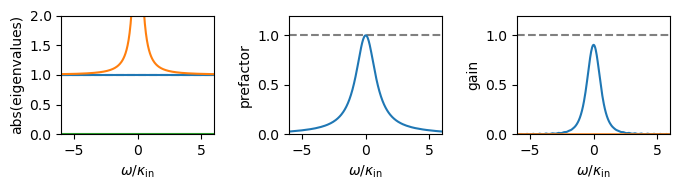

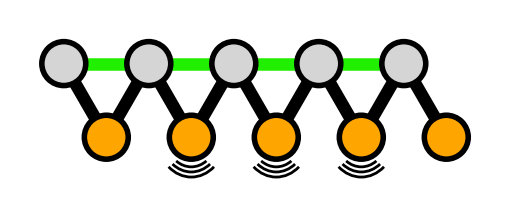

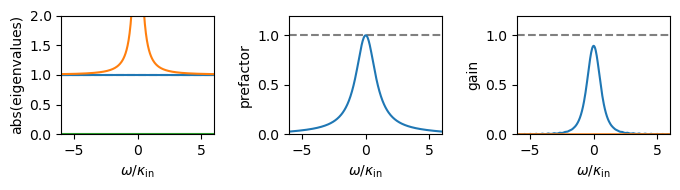

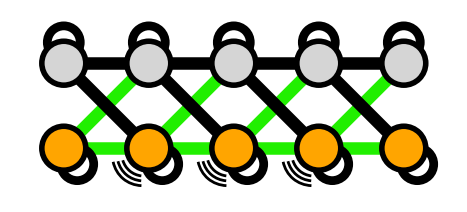

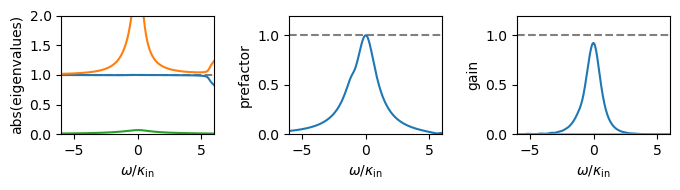

In [8]:
idxs_to_plot = [0,2,6]

num_unit_cells = 5

for idx in idxs_to_plot:
    if idx == 6:
        list_of_kwargs_noise = [{'opening_angles': [50,54,58]},  {'opening_angles': [50,54,58]}]
        noise_orientations=[np.pi+0.7, -0.7]
        # orientation_detunings = [np.pi-0.7,0.7]
        orientation_detunings = [np.pi-0.7,0.]
        kwargs_draw={'node_size': 1000, 'detuning_offset_factor': 0.95, 'detuning_radius_factor': 0.75, 'detuning_width_factor': 0.7}
    else:
        list_of_kwargs_noise = [arch.default_kwargs_noise, arch.default_kwargs_noise]
        noise_orientations=[np.pi, 0]
        kwargs_draw={'node_size': 1000, 'detuning_offset_factor': 0.95, 'detuning_radius_factor': 0.85, 'detuning_width_factor': 0.75}
        orientation_detunings=None
        
    if idx == 0:
        positions = [(0, 0), (1/2,np.sqrt(3)/2)]
    if idx == 2:
        positions = [(1/2, 0), (0,np.sqrt(3)/2)]
    if idx == 6:
        positions = 'straight'

    filename_part = os.path.join(figures_folder, 'no_squeezing-%i'%idx)
        
    fig, ax, G = arch.draw_chain_cell(
        irreducible_graphs_no_squeezing[idx],
        num_following_unit_cells=num_unit_cells-1,
        positions_unit_cell=positions,
        distance_next_unit_cell=1,
        node_colors_unit_cell=['orange', '#D5D5D5'],
        filename=filename_part+'-chain.pdf',
        # filename=os.path.join(figures_folder, str(idx).zfill(3) + '-chain.pdf'),
        noise_orientations=noise_orientations,
        orientation_detunings=orientation_detunings,
        kwargs_draw=kwargs_draw,
        list_of_kwargs_noise=list_of_kwargs_noise,
        modes_without_noise=[0,-2,1,3,5,7,9]
    )

    fig_scaling, _ = make_isolator_plot(irreducible_graphs_solutions_no_squeezing[idx], opt_no_squeezing.plot_functions)
    fig_scaling.savefig(filename_part + '-gain.pdf')

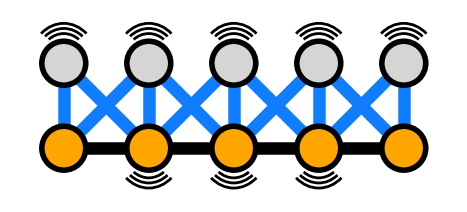

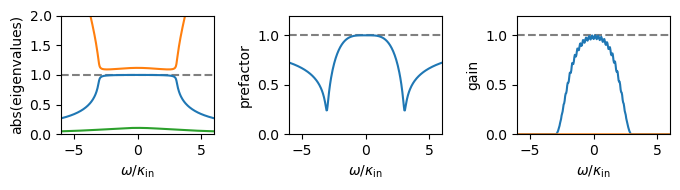

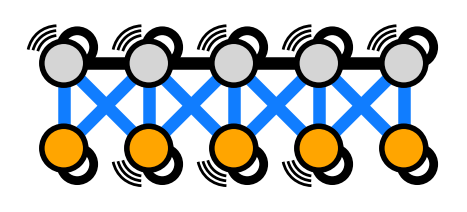

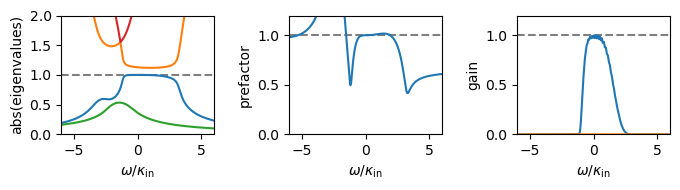

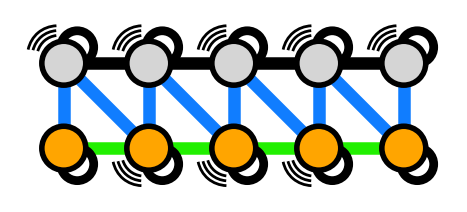

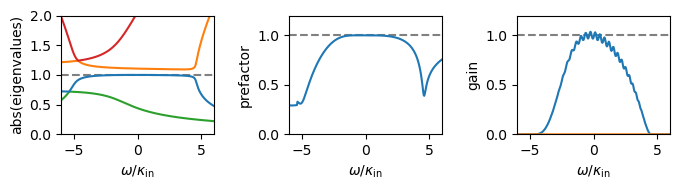

In [9]:
idxs_to_plot = np.arange(len(irreducible_graphs_squeezing))

for idx in idxs_to_plot:
    if idx == 1 or idx == 2:
        list_of_kwargs_noise = [{'opening_angles': [50,54,58]},  {'opening_angles': [50,54,58]}]
        noise_orientations=[np.pi+0.7, -0.7]
        orientation_detunings = [np.pi-0.7,0.7]
        kwargs_draw={'node_size': 1000, 'detuning_offset_factor': 0.95, 'detuning_radius_factor': 0.75, 'detuning_width_factor': 0.7}
    else:
        list_of_kwargs_noise = [arch.default_kwargs_noise, arch.default_kwargs_noise]
        noise_orientations=[np.pi, 0]
        kwargs_draw={'node_size': 1000, 'detuning_offset_factor': 0.95, 'detuning_radius_factor': 0.85, 'detuning_width_factor': 0.75}
    
    filename_part = os.path.join(figures_folder, 'squeezing-%i'%idx)

    fig, ax, G = arch.draw_chain_cell(
        irreducible_graphs_squeezing[idx],
        num_following_unit_cells=num_unit_cells-1,
        positions_unit_cell='straight',
        distance_next_unit_cell=1,
        node_colors_unit_cell=['orange', '#D5D5D5'],
        filename=filename_part+'-chain.pdf',
        # filename=os.path.join(figures_folder, 'squeezing-' + str(idx).zfill(3) + '-chain.pdf'),
        noise_orientations=noise_orientations,
        orientation_detunings=orientation_detunings,
        kwargs_draw=kwargs_draw,
        mode_types=[True, False, True],
        list_of_kwargs_noise=list_of_kwargs_noise,
        modes_without_noise=[0,-2]
    )

    fig_scaling, _ = make_isolator_plot(irreducible_graphs_solutions_squeezing[idx], opt_squeezing.plot_functions)
    fig_scaling.savefig(filename_part + '-gain.pdf')
